# Hyperparámetros y Validación de Modelos

En la sección anterior vimos la receta básica para aplicar un modelo supervisado de machine learning:

  1. Elegir una clase de modelo
  2. Elegir los hiperparámetros del modelo
  3. Ajustar el modelo a los datos de entrenamiento
  4. Usar el modelo para predecir etiquetas de datos nuevos
  
Las primeras dos etapas son posiblemente las más importantes para usar estas herramientas y técnicas de manera efectiva.
Para realizar una elección informada, necesitamos un modo de _validar_ que nuestro modelo y nuestros hiperparámetros son adecuados para nuestros datos.
Aunque esto suene simple, hay algunas trampas que debes eludir para hacerlo bien.

## Pensando sobre Validación de Modelos

En principio, validar un modelo es sencillo: después de elegir un modelo y sus hiperparámetros, podemos estimar qué tan efectivo es si lo aplicamos a los datos de entrenamiento y comparamos la predicción con el valor ya conocido.

Primero veremos un enfoque ingenuo a la validación de modelos, y reflexionaremos respecto a por qué falla, antes de explorar el uso de _holdout sets_ (subconjunto de los datos dejado fuera del ajuste) y _cross validation_ (validación cruzada) para una evaluación robusta de modelos.

### Cómo hacer mal una validación

Veamos el enfoque ingenuo utilizando el dataset Iris, que ya vimos anteriormente. Comencemos cargando los datos:

In [1]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

Elijamos un modelo y sus hiperparámetros. Usamos un clasificador conocido como _k-neighbors_ con un hiperparámetro ``n_neighbors=1``.
Este es un modelo simple e intuitivo que dice "la etiqueta de una observación desconocida es la misma que la de las observaciones utilizadas en entrenamiento que están más cerca."

In [2]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)

Luego entrenamos el modelo, y lo usamos para predecir etiquetas para datos que ya conocemos:

In [3]:
model.fit(X, y)
y_model = model.predict(X)

Finalmente, computamos la fracción de puntos que fueron etiquetados correctamente:

In [4]:
from sklearn.metrics import accuracy_score
accuracy_score(y, y_model)

1.0

¡La _accuracy_ de 1.0 indica que el 100% de los puntos fueron correctamente clasificados por nuestro modelo!
Pero, ¿estamos realmente midiendo la eficacia ddel modelo?¿Realmente estamos frente a un modelo que estará en lo correcto el 100% del tiempo?

 

Como habrán imaginado, la respuestas es _no_.
De hecho, ese enfoque tiene una falla fundamental: _entrena y evalúa el modelo en los mismos datos_.

En este caso, el modelo _k-neighbors_ es un estimador basado en _instancias_ que simplemente almacena los datos de entrenamiento, y predice etiquetas al comparar datos nuevos con aquellos que han sido almacenados. Excepto en casos excepcionales, _siempre_ va a obtener 100% de _accuracy_ si se evalúa con los datos de entrenamiento.

### La manera correcta: _Holdout sets_

¿Qué se puede hacer entonces?
Una manera mejor de tener una noción de cómo se comportaría un modelo es usando lo que se conoce como _holdout set_: dejamos a un lado una parte de los datos a la hora de entrenar el modelo, y usamos ese dataset reservado para revisar el desempeño del modelo.
Esta separación se puede hacer con el método ``train_test_split`` en Scikit-Learn:

In [5]:
from sklearn.cross_validation import train_test_split
# divide el dataset mitad y mitad
X1, X2, y1, y2 = train_test_split(X, y, random_state=0,
                                  train_size=0.5)

# ajusta el modelo en una de las mitades
model.fit(X1, y1)

# evalua el modelo en la otra mitad
y2_model = model.predict(X2)
accuracy_score(y2, y2_model)

/home/egraells/.virtualenvs/jupyter/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


0.9066666666666666

Este resultado es más razonable: el clasificador de vecinos cercanos acierta cerca del 90% de los casos en este _holdout set_.
Este dataset de validación es similar a datos desconocidos, porque el modelo no lo ha "visto" antes.

### Validación usando _cross-validation_ (validación cruzada)

Una desventaja de separar el dataset es que hemos perdido una fracción de los datos para entrenar el modelo.
En el caso anterior, la mitad del dataset no contribuye al entrenamiento del modelo. 
Esto no es óptimo y puede causar problemas, especialmente si el set de entrenamiento es pequeño.

Una manera de enfrentar esta situación es la _validación cruzada_, es decir, realizar una secuencia de ajustes donde cada subconjunto de los datos es utilizado tanto como training como validación. Visualmente, se ve más o menos así:

![](figures/05.03-2-fold-CV.png)

Aquí hacemos dos pruebas de validación, alternando el rol de cada mitad como _holdout set_.
Usuando los datos tal como los dividimos antes, lo podríamos implementar así:

In [6]:
y2_model = model.fit(X1, y1).predict(X2)
y1_model = model.fit(X2, y2).predict(X1)
accuracy_score(y1, y1_model), accuracy_score(y2, y2_model)

(0.96, 0.9066666666666666)

Obtenemos dos puntajes de precisión, que podríamos combinar (por ej., tomando su promedio) para tener una mejor medida del desempeño global del modelo.
Esta forma particular de validación cruzada es llamada _two-fold cross-validation_, es decir, una en que hemos dividido los datos en dos y usado cada parte como set de validación en cada prueba.

Podemos expandir esta idea a más pruebas, y más divisiones del dataset. Por ejemplo, aquí hay una representación visual de una validación cruzada _5-fold_:

![](figures/05.03-5-fold-CV.png)

Aquí dividimos los datos en cinco grupos, y usamos cada uno en una prueba para evaluar el desempeño del modelo en la parte restante (4/5) de los datos.
Esto podría ser tedioso de hacer a mano. Para ello podemos usar el método de conveniencia ``cross_val_score`` de Scikit-Learn:

In [7]:
from sklearn.cross_validation import cross_val_score
cross_val_score(model, X, y, cv=5)

array([0.96666667, 0.96666667, 0.93333333, 0.93333333, 1.        ])

Repetir la validación en diferentes subconjuntos de los datos nos da una mejor idea del desempeño del algoritmo.

Scikit-Learn implementa varios esquemas de validación cruzada que son útiles para situaciones específicas; son implementadas como iteradores en el módulo ``cross_validation``.
Por ejemplo, podríamos querer ir al extremo donde el número de subconjuntos es igual al tamaño del dataset: es decir, entrenamos en todas las muestras excepto una en cada prueba. 
Este tipo de validación cruzada se llama _dejar-uno-afuera_ (_leave-out-out_), y se puede implementar como sigue:

In [8]:
from sklearn.cross_validation import LeaveOneOut
scores = cross_val_score(model, X, y, cv=LeaveOneOut(len(X)))
scores

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Como tenemos 150 muestras, la validación cruzada contiene puntajes para 150 pruebas. El puntaje indica si la predicción de esa muestra fue exitosa (1.0) o un fracaso (0.0).
Tomar el promedio del arreglo nos da un estimado de la tasa de éxito del modelo:

In [9]:
scores.mean()

0.96

Otros esquemas se pueden usar de manera similar. 
Para una descripción de lo que está disponible en Scikit-Learn, usa Jupyter para explorar el módulo ``sklearn.cross_validation``, o dale una mirada a la [documentación de validación cruzada](http://scikit-learn.org/stable/modules/cross_validation.html).

## Eligiendo el Mejor Modelo

Ahora que hemos visto lo básico de validar y de la validación cruzada, profundizaremos un poco en lo que respecta a la selección de modelos e hiperparámetros.
Ambas cosas son uno de los aspectos más importantes en la práctica, y creo que esta información a veces se ve superficialmente en los tutoriales de introducción al aprendizaje automático.

La siguiente pregunta es crucial: _si nuestro estimador no tiene buen desempeño, ¿cómo seguimos avanzando?

Posibles respuestas:

- Usa un modelo más complejo o más flexible
- Usa un modelo menos complejo o menos flexible
- Agranda el set de entrenamiento
- Añade más características a cada muestra

La respuesta suele ser contra-intuitiva.
En particular, a veces usar un modelo más complejo dará peores resultados, y añadir más datos no necesariamente mejorará el desempeño.
La habilidad de determinar el camino a seguir para mejorar tu modelo es lo que separa a les practicantes exitoses de machine learning de los demás.

### El _trade-off_ entre Sesgo (_Bias_) y Varianza

Fundamentalmente, la búsqueda del "mejor modelo" intenta encontrar el punto perfecto en el trade-off entre sesgo y varianza.
Considera la siguiente imagen, que presenta dos regresiones ajustadas al mismo dataset:

![](figures/05.03-bias-variance.png)

Está claro que ninguno de los dos modelos presenta un buen ajuste a los datos, pero ambos fallan en maneras distintas.

El modelo de la izqueirda intenta encontrar una línea recta que se ajuste a los datos.
Como los datos son intrínsecamente no lineales, el modelo de recta nunca será capaz de describir bien el dataset.
De un modelo así se dice que _infraajusta_ (_underfits_) los datos, es decir, no es lo suficientemente flexible como para dar cuenta de todas las propiedades de los datos; otra manera de decir esto es que el modelo es altamente sesgado.

El modelo en la derecha intenta ajustar un polinomio de alto nivel a los datos.
Aquí el modelo tiene suficiente flexibilidad para ajustar casi perfectamente características finas de los datos, pero incluso si describe con alta precisión los datos de entrenamiento, su forma tan precisa parece ser más un reflejo del ruido en los datos que de las propiedades del proceso intrínseco (sea cual sea) que haya generado los datos.
De un modelo así se dice que _sobreajusta_ (_overfits_) los datos, es decir, tiene tanta flexibilidad que el modelo termina dando cuenta de errores aleatorios tanto como de la distribución implícita de los datos; otra manera de decir esto es que el modelo tiene alta varianza.

Para ver el problema desde otra perspectiva, considera lo que sucede si usamos los dos modelos para predecir valores de y para datos nuevos de X.
En el siguiente diagrama, los puntos de color naranja son omitidos del dataset de entrenamiento:

![](figures/05.03-bias-variance-2.png)

Como métrica de desempeño usaremos el [coeficiente de determinación](https://en.wikipedia.org/wiki/Coefficient_of_determination) $R^2$, que mide qué tan bien se comporta un modelo en relación al promedio de los valores objetivo. $R^2=1$ significa un desempeño perfecto, $R^2=0$ significa que el modelo no es mejor que simplemente tomar el promedio delos datos y usarlo como predicción, y valores negativos son modelos incluso peores qué ese (sí, existen).
Desde los puntajes obtenidos en ambos modelos, podemos hacer la siguiente observación:

- Para modelos de alto sesgo, el desempeño del modelo en el set de validación es similar al del desempeño de entrenamiento.
- Para modelos de alta varianza, el desempeño del modelo en el set de validación es extremadamente malo en comparación con el set de entrenamiento.

Si imaginamos que tenemos la habilidad de ajustar la complejidad de un modelo, esperaríamos que los puntajes de entrenamiento y validación se comporten como en la siguiente imagen:

![](figures/05.03-validation-curve.png)

El diagrama muestra lo que se suele llamar _curva de validación_, donde se observan las siguientes características:

- El puntaje de entrenamiento siempre es mayor al de validación. Este es generalmente el caso: el modelo dará mejores resultados para datos que ha visto que para datos que no ha visto.
- Para modelos de baja complejidad (alto sesgo), los datos de entrenamiento son infraajustados, lo que significa que el modelo es un predictor pobre tanto para los datos como para cualquier dato no visto previamente.
- Para modelos de alta complejidad (alta varianza), los datos de entrenamiento son sobreajustados, lo que significa que el modelo predice muy bien los datos de entrenamiento, pero falla para cualquier dato no visto previamente.
- Para algún valor intermedio, la curva de validación tiene un máximo. Este nivel de complejidad indica un trade-off apropiado entre sesgo y varianza.

Los modos de configurar la complejidad varían de modelo a modelo; cuando discutamos modelos individuales en las próximas clases veremos cómo podemos llevar a cabo este proceso para cada uno de ellos.

### Curvas de Validación en Scikit-Learn

Veamos un ejemplo de usar validación cruzada para computar la curva de validación de una clase de modelos.
Utilizaremos un modelo de _regresión polinomial_, un modelo lineal generalizado en el que el grado del polinomio se puede configurar.
Por ejemplo, un polinomio de un grado ajusta una recta a los datos; para parámetros $a$ y $b$ del modelo:

$$
y = ax + b
$$

Un polinomio de grado tres ajusta una curva cúbica a los datos; para parámetros $a$, $b$, $c$ y $d$:

$$
y = ax^3 + bx^2 + cx + d
$$

Esto lo podemos generalizar a cualquier número, es decir, a cualquier grado del polinomio.
En Scikit-Learn podemos implementar esto al combinar una regresión lineal con un preprocesador polinomial que genera las combinaciones necesarias para las características de cada muestra.
Para ello podemos usar una _cadena_ (_pipeline_) que enlace ambas operaciones (discutiremos las características polinomiales y las cadenas en la clase de Ingeniería de Características):

In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

Ahora creemos datos para los cuales ajustaremos el modelo:

In [11]:
import numpy as np

def make_data(N, err=1.0, rseed=1):
    # creamos un generador de números aleatorios
    rng = np.random.RandomState(rseed)
    # generamos números y los elevamos al cuadrado
    X = rng.rand(N, 1) ** 2
    # creamos un arreglo objetivo para las observaciones
    y = 10 - 1. / (X.ravel() + 0.1)
    # perturbamos el arreglo objetivo con un error aleatorio
    if err > 0:
        y += err * rng.randn(N)
    return X, y

# generemos 40 puntos
X, y = make_data(40)

Visualicemos estos datos, en conjunto con distintos ajustes del regresor polinomial:

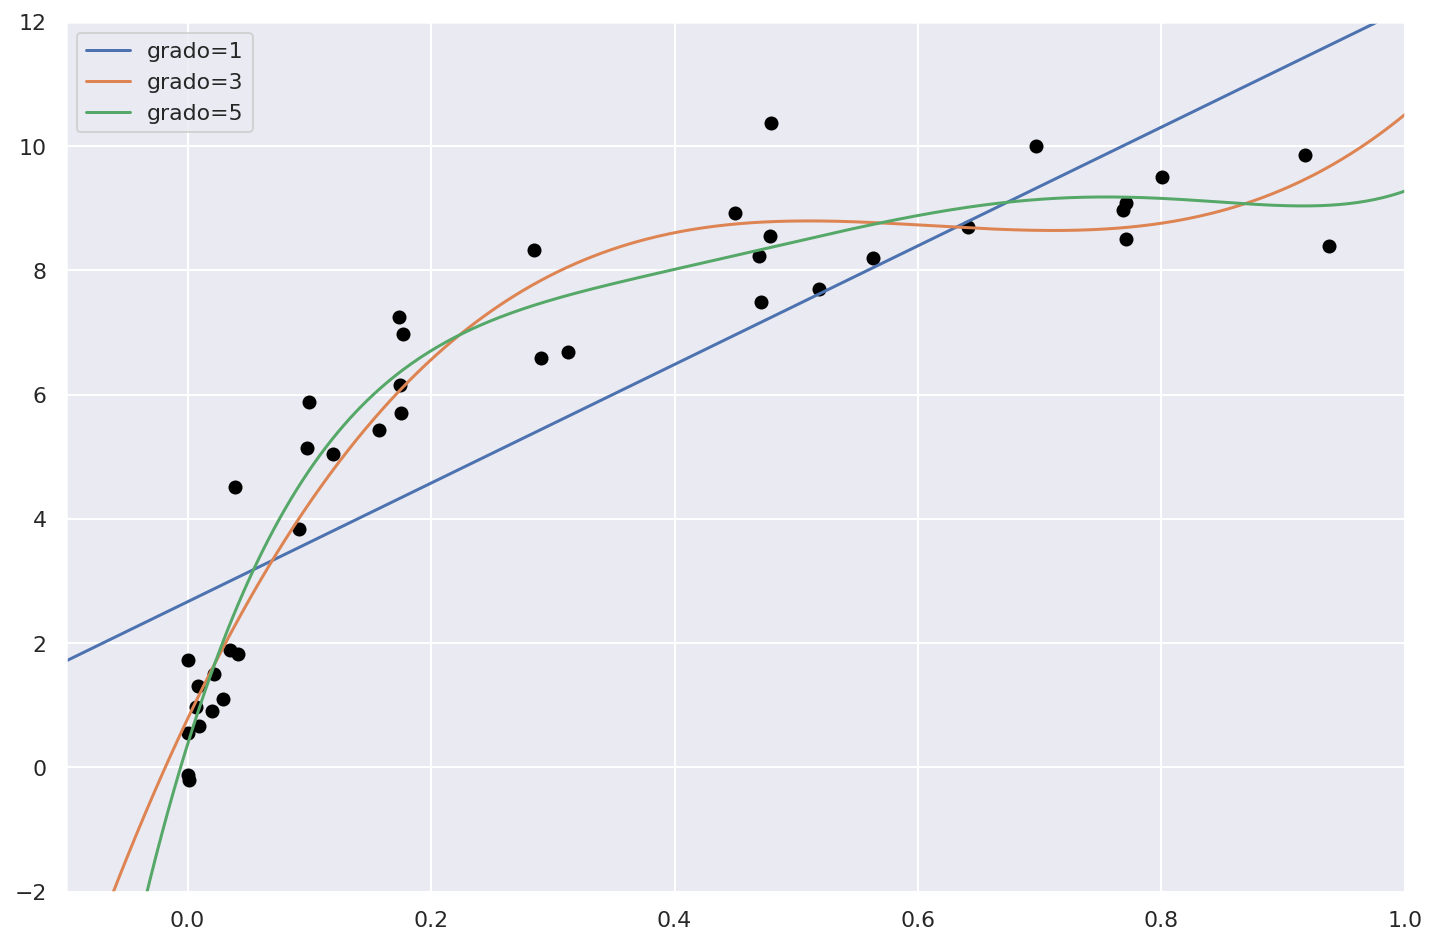

In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # plot formatting

X_test = np.linspace(-0.1, 1.1, 500)[:, None]

plt.figure(figsize=(12,8))
plt.scatter(X.ravel(), y, color='black')
axis = plt.axis()
for degree in [1, 3, 5]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='grado={0}'.format(degree))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best');

La complejidad del modelo en este caso es controlada por el grado del polinomio de regresión, que puede ser cualquier número entero positivo.
Una pregunta útil a realizar es: _¿cuál es el grado del polinomio que provee un trade-off adecuado entre sesgo (infraajuste) y varianza (sobreajuste)??_

Podemos avanzar en esta dirección al visualizar la curva de validación para este modelo y datos en específico; esto se puede hacer directamente con el método ``validation_curve`` provisto por Scikit-Learn.
Dado un modelo, datos, nombre de parámetro, y un rango de valores a explorar, esta función automáticaqmente computa tanto el puntaje de entrenamiento como el de validación a lo largo del rango pedido:

In [13]:
PolynomialRegression()

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

/home/egraells/.virtualenvs/jupyter/lib/python3.5/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


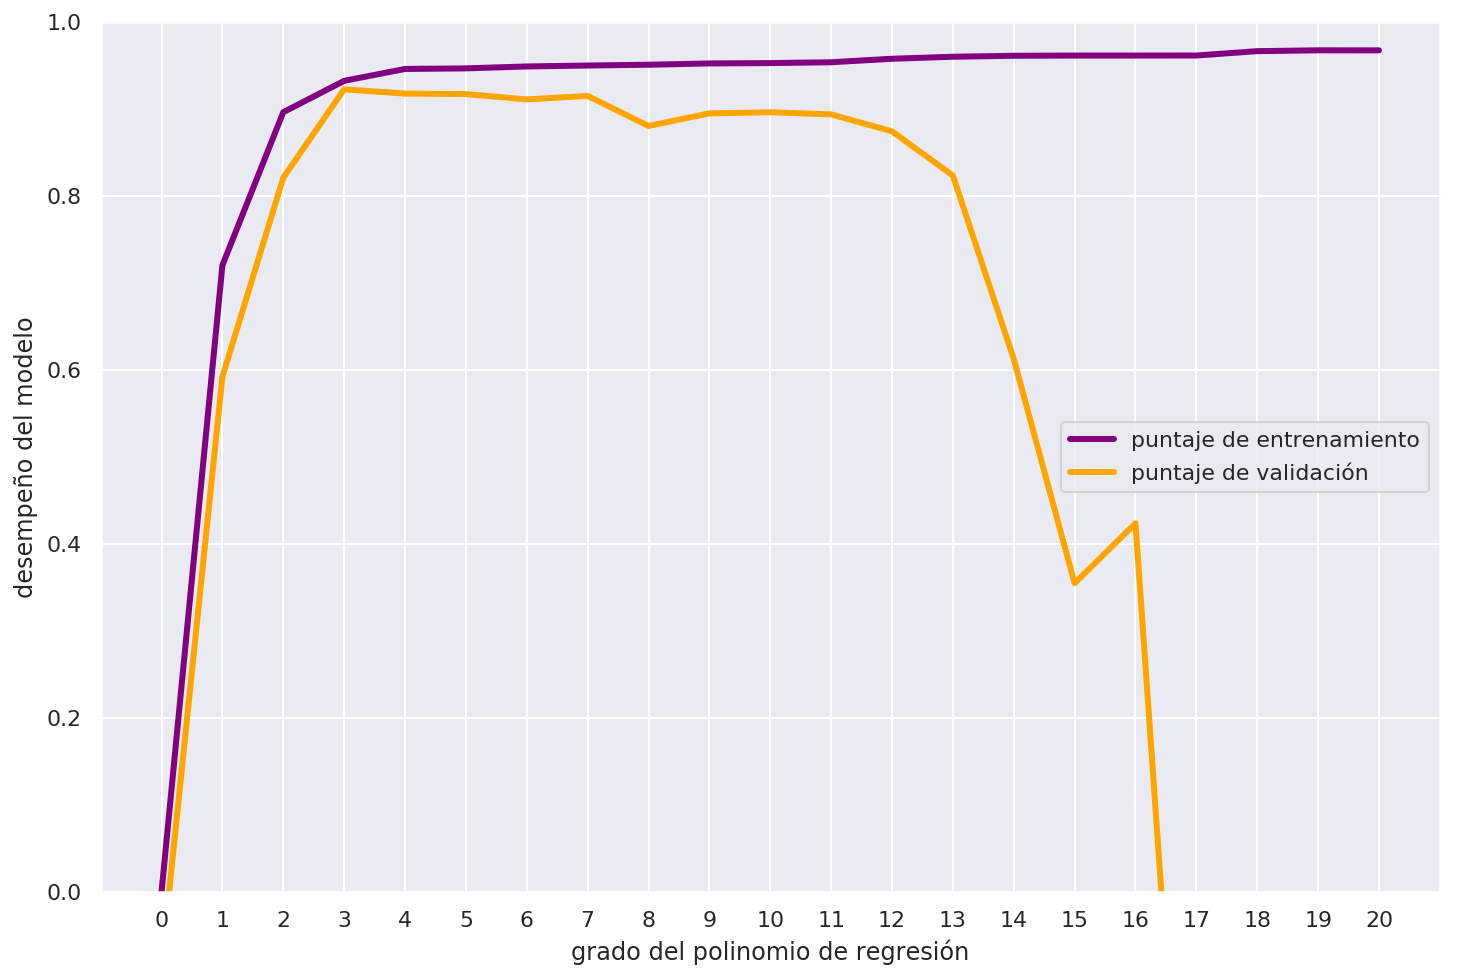

In [14]:
from sklearn.learning_curve import validation_curve
degree = np.arange(0, 21)
train_score, val_score = validation_curve(PolynomialRegression(), X, y,
                                          'polynomialfeatures__degree', degree, cv=7)

plt.figure(figsize=(12,8))
plt.plot(degree, np.median(train_score, 1), color='purple', linewidth=3, label='puntaje de entrenamiento')
plt.plot(degree, np.median(val_score, 1), color='orange', linewidth=3, label='puntaje de validación')
plt.legend(loc='best')
plt.xticks(range(0,21))
plt.ylim(0, 1)
plt.xlabel('grado del polinomio de regresión')
plt.ylabel('desempeño del modelo');

El gráfico muestra precisamente el comportamiento cualitativo que esperamos: el puntaje de entrenamiento siempre es más alto que el de validación; también mejora siempre que se incrementa la complejidad del modelo; y el puntaje de validación encuentra un máximo antes de caer estrepitosamente a medida que el modelo se sobreajusta.

De la curva de validación inferimos que el trade-off óptimo entre sesgo y varianza sucede en el polinomio de tercer orden; podemos calcular y visualizar este ajuste en los datos originales como sigue:

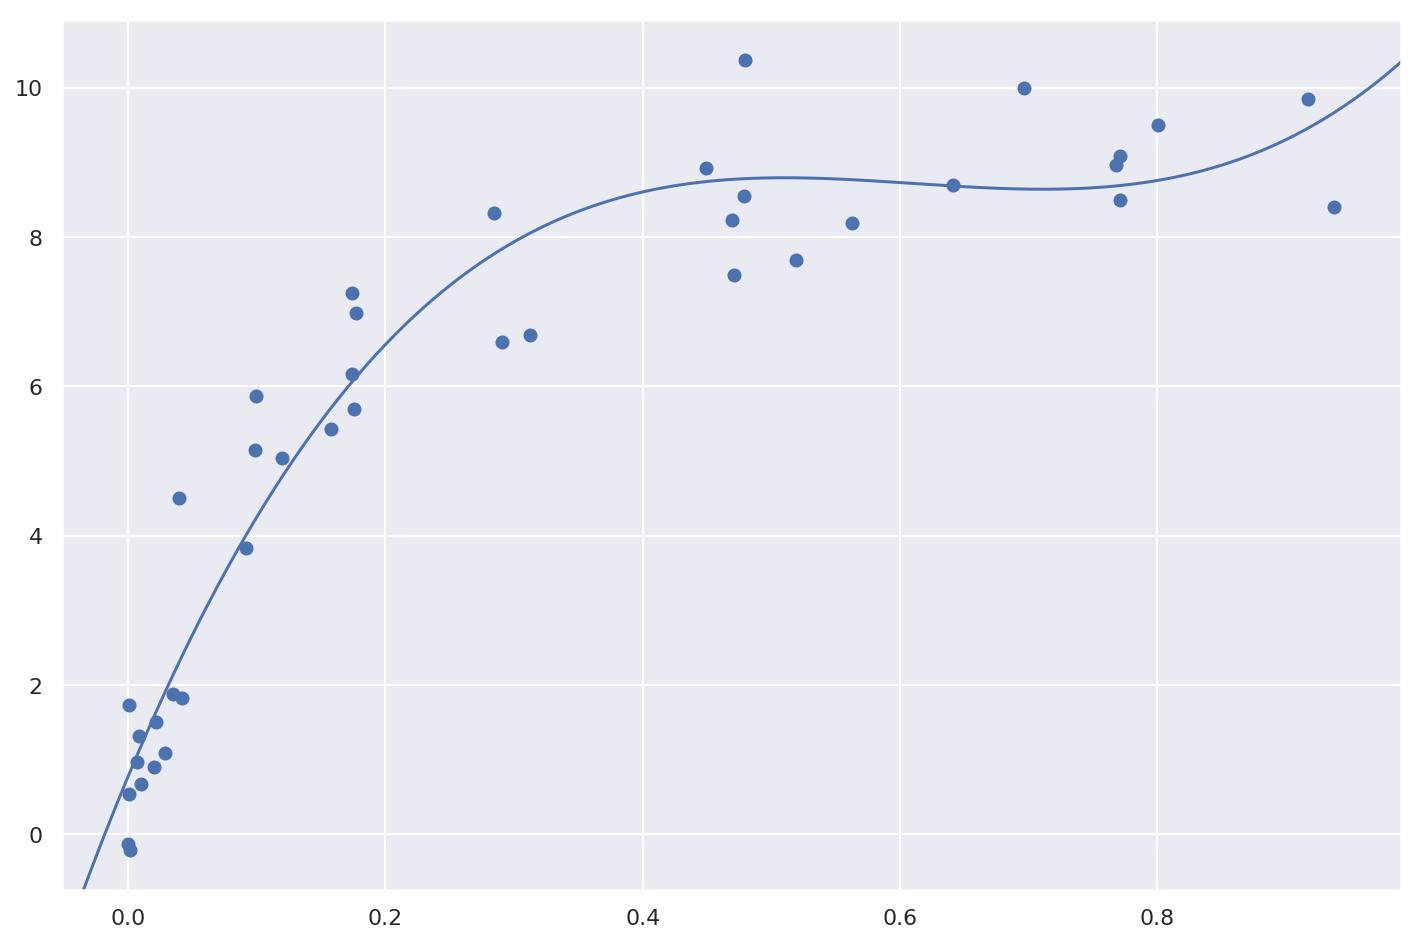

In [15]:
plt.figure(figsize=(12,8))
plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = PolynomialRegression(3).fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);

Nota que para encontrar este modelo óptimo no nos fijamos en el puntaje de entrenamiento, sino que examinamos la relación entre puntaje de entrenamiento y validación. Esta relación es la que nos puede dar _insights_ respecto al desempeño de un modelo.

## Curvas de Aprendizaje

Un aspecto importante de la complejidad es que un modelo óptimo usualmente dependerá del tamaño de tus datos de entrenamiento.
Por ejemplo, generemos otro dataset con cinco veces más datos que antes:

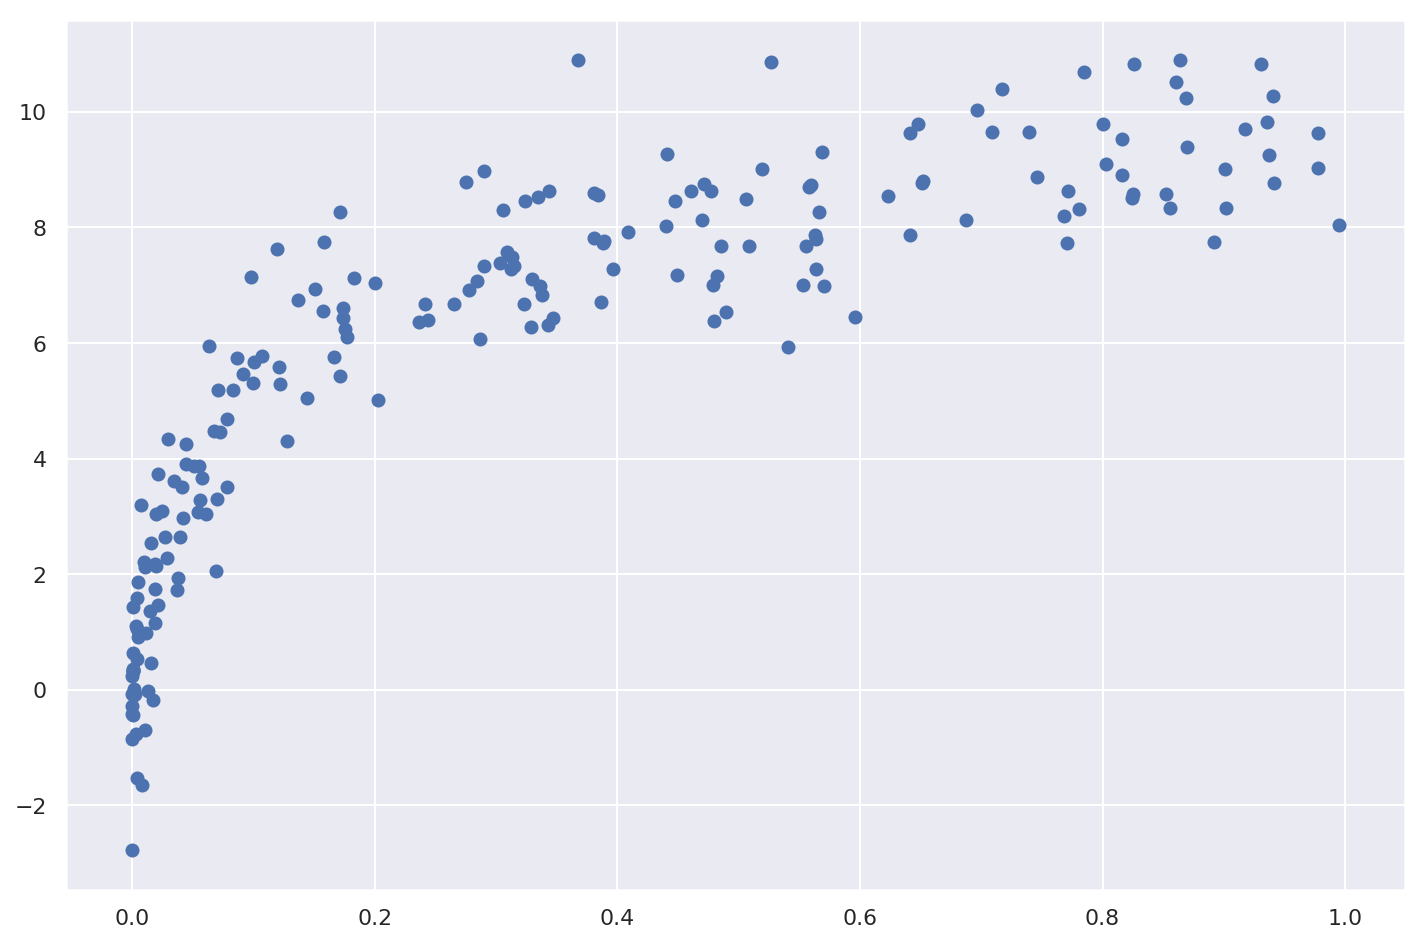

In [16]:
X2, y2 = make_data(200)
plt.figure(figsize=(12,8))
plt.scatter(X2.ravel(), y2);

Hagamos lo mismo que antes, duplicando el código, para ver qué sucede en la curva de validación para este dataset más grande. Como referencia, también graficaremos los resultados del proceso anterior:

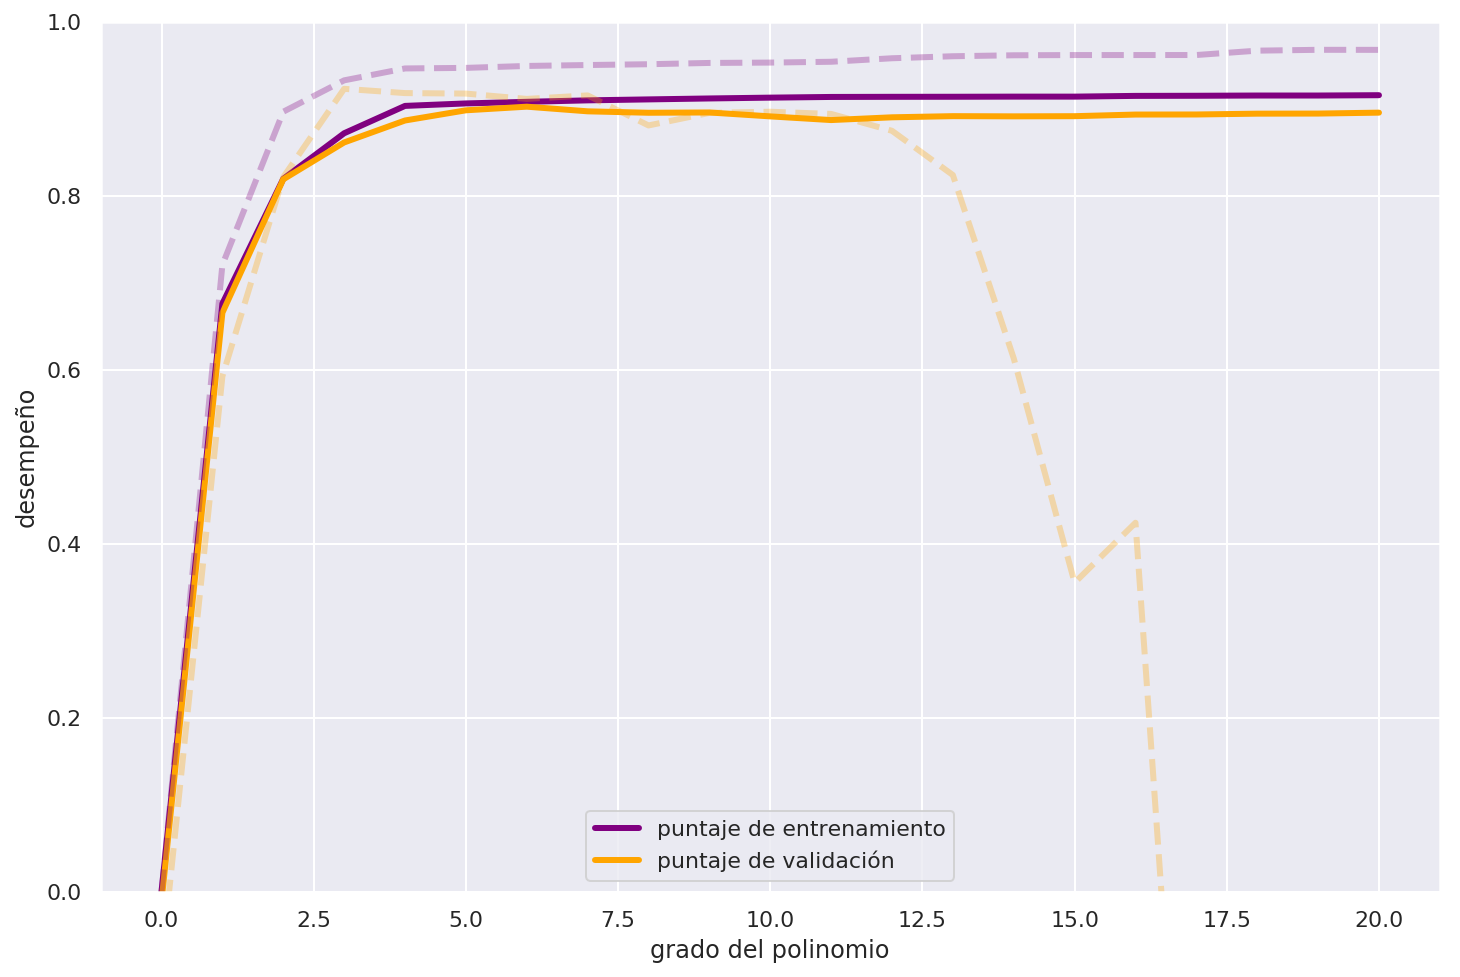

In [17]:
degree = np.arange(21)
train_score2, val_score2 = validation_curve(PolynomialRegression(), X2, y2,
                                            'polynomialfeatures__degree', degree, cv=7)

plt.figure(figsize=(12,8))
plt.plot(degree, np.median(train_score2, 1), color='purple', linewidth=3, label='puntaje de entrenamiento')
plt.plot(degree, np.median(val_score2, 1), color='orange', linewidth=3, label='puntaje de validación')
plt.plot(degree, np.median(train_score, 1), color='purple', alpha=0.3, linewidth=3, linestyle='dashed')
plt.plot(degree, np.median(val_score, 1), color='orange', alpha=0.3, linewidth=3, linestyle='dashed')
plt.legend(loc='lower center')
plt.ylim(0, 1)
plt.xlabel('grado del polinomio')
plt.ylabel('desempeño');

Las líneas sólidas muestran los nuevos resultados, mientras que las líneas segmentadas muestran los resultados previos, con el dataset más pequeño.
Es claro desde la curva de validación que el dataset más largo puede soportar a un modelo más complicado: el _peak_ está probablemente cerca del grado seis, pero incluso veinte grados no han sobreajustado el modelo: los puntajes de validación y entrenamiento siguen estando cerca.

Entonces, vemos que el comportamiento de la curva de validación no tiene uno sino que dos entradas importante: la complejidad del modelo y el tamaño del dataset de entrenamiento.
Suele ser útil explorar el comportamiento del modelo en función del número de puntos de entrenamiento, que podemos hacer incrementando el tamaño del dataset que usamos para ajustar nuestro modelo en secuencia.
Un gráfico del puntaje de entrenamiento/validación con respecto al tamaño del dataset es conocido como _curva de aprendizaje_ (_learning curve_).

El comportamiento general que esperaríamos de una curva de aprendizaje es el siguiente:

- Un modelo de una complejidad dada hará sobreajuste a un dataset pequeño: esto significa que el puntaje de entrenamiento será relativamente alto, mientras que el puntaje de validación será relativamente bajo.
- Un modelo de una complejidad dada hará infraajuste de un dataset grande: esto significa que el puntaje de entrenamiento disminuirá, pero el puntaje de validación se incrementará. 
- Un modelo nunca, a menos que sea suerte, dará un mejor puntaje al set de validación que al de entrenamiento: esto significa que estas curvas debiesen acercarse pero nunca van a cruzarse.

Teniendo esto en mente, esperaríamos que una curva de aprendizaje se viese como en la siguiente imagen:

![](figures/05.03-learning-curve.png)

La característica notable de la curva de aprendizaje es como converge hacia un puntaje específico a medida que crece el tamaño del dataset de entrenamiento.
En particular, una vez que tienes suficientes puntos para saber que el modelo ha convergido, _¡agregar más datos no te va a ayudar!_ 
En ese caso, la única manera de mejorar el desempeño es utilizar otro modelo (que suele ser más complejo).

### Curvas de Aprendizaje en Scikit-Learn

Scikit-Learning ofrece herramientas convenientes para computar curvas de aprendizaje en tus modelos; aquí computaremos la curva para nuestro dataset original con polinomios de segundo y noveno orden:

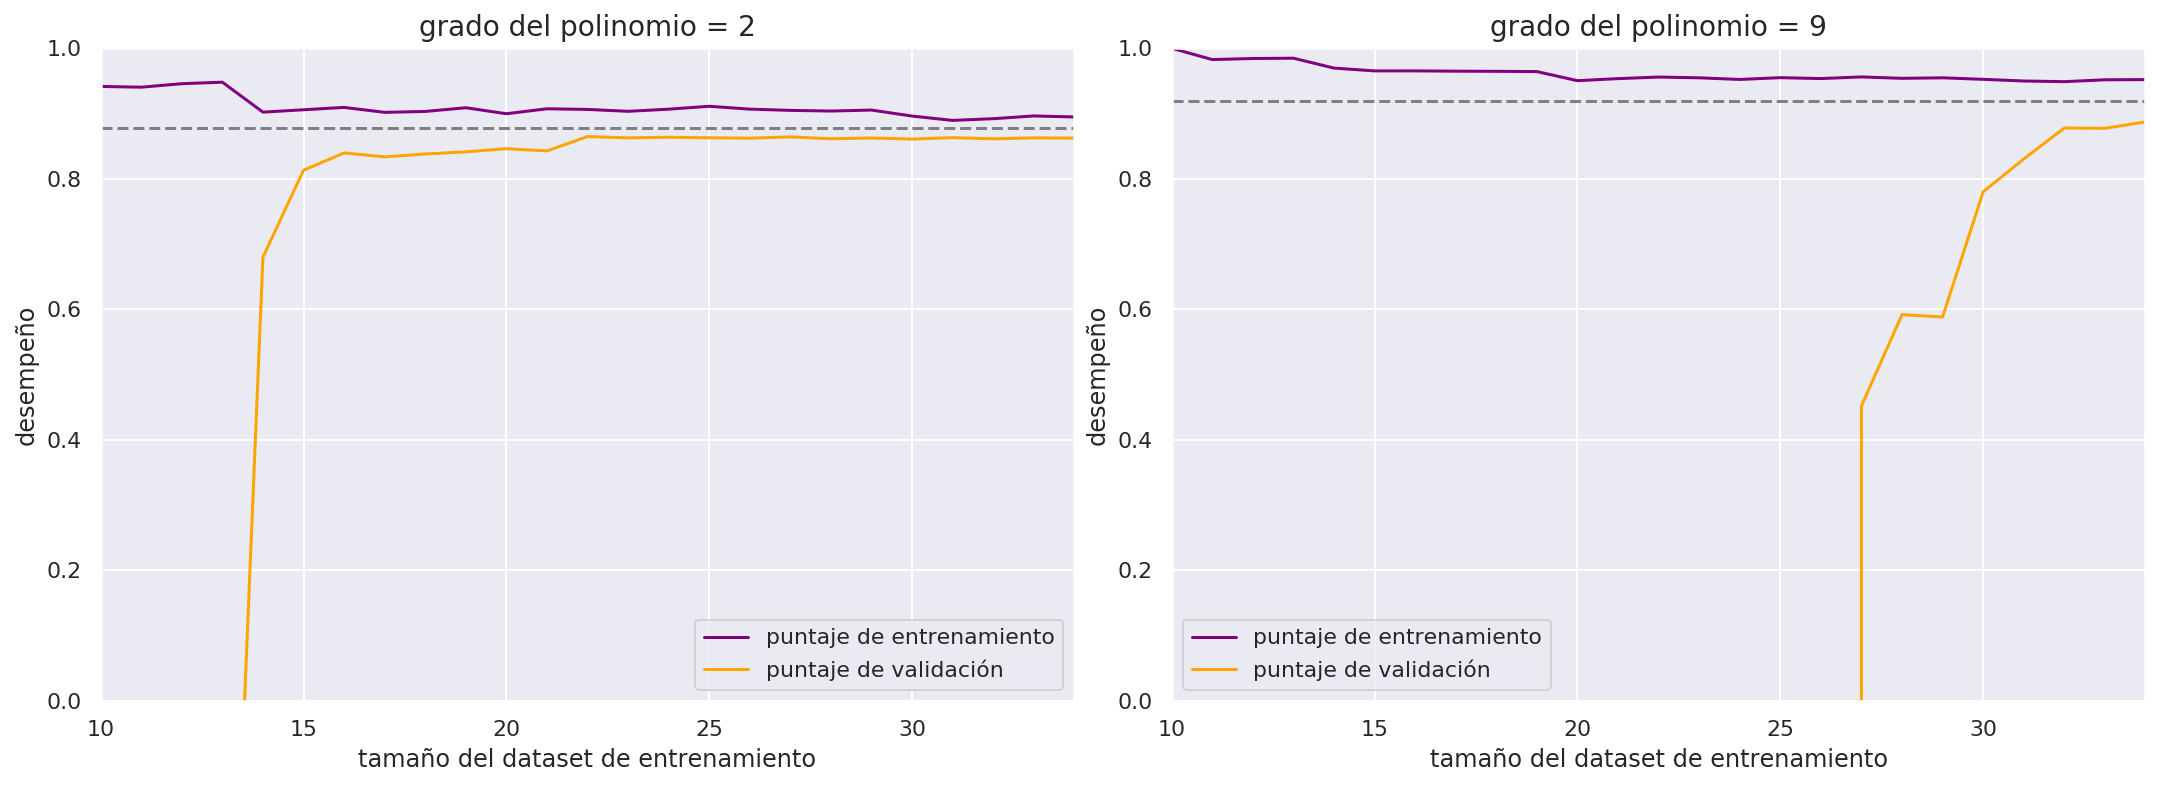

In [18]:
from sklearn.learning_curve import learning_curve

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for i, degree in enumerate([2, 9]):
    N, train_lc, val_lc = learning_curve(PolynomialRegression(degree),
                                         X, y, cv=7,
                                         train_sizes=np.linspace(0.3, 1, 25))

    ax[i].plot(N, np.mean(train_lc, 1), color='purple', label='puntaje de entrenamiento')
    ax[i].plot(N, np.mean(val_lc, 1), color='orange', label='puntaje de validación')
    ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1],
                 color='gray', linestyle='dashed')

    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(N[0], N[-1])
    ax[i].set_xlabel('tamaño del dataset de entrenamiento')
    ax[i].set_ylabel('desempeño')
    ax[i].set_title('grado del polinomio = {0}'.format(degree), size=14)
    ax[i].legend(loc='best')

Este diagnóstico es de valor, porque nos muestra una codificación visual de cómo nuestro modelo responde ante el tamaño del set de entrenamiento.
En particular, cuando tu curva de aprendizaje ha convergido, agregar más datos ya no mejorará el ajuste, como se observa en el panel de la izquierda, con la curva de aprendizaje para un modelo cuadrático.

La única manera de mejorar el puntaje de convergencia es usando un modelo diferente, usualmente uno más complicado, como en el segundo panel: al aumentar el grado del modelo a nueve, mejoramos el puntaje de convergencia (marcado por la línea gris), con el costo de tener una mayor varianza en el modelo (indicada por la diferencia entre los puntajes de entrenamiento y validación).
Si agregásemos aún más datos, la curva de aprendizaje del modelo más complicado convergería eventualmente.

Graficar una curva de aprendizaje para el modelo y datos que has elegido te ayudará a realizar este tipo de decisiones y a mejorar tu análisis.

## Validación en la Práctica: Búsqueda en la Grilla (_Grid Search_)

La discusión previa busca darte una intuición respecto al trade-off entre sesgo y varianza, y su dependencia en la complejidad del modelo y el tamaño del set de entrenamiento.
En la práctica, los modelos tendrán más que un parámetro a configurar,y por tanto los gráficos de validación y curvas de aprendizaje cambiarán desde líneas hacia superficies multidimensionales.
Dichas visualizaciones son difíciles de realizar (y entender), por lo que simplemente quisiéramos quedarnos con el modelo específico que maximice el puntaje de validación.

Scikit-Learn provee herramientas automatizadas para  hacer todo esto, en el módulo de búsqueda grillada (_grid search_).
Aquí hay un ejemplo de cómo usar _grid search_ para encontrar el modelo polinomial óptimo.
Exploraremos una grilla de tres dimensiones de características del modelo: el grado polinomial, si la regresión debe considerar la intercepta, y si la regresión debe normalizar el problema.
Esto se puede realizar con el meta-estimador llamado ``GridSearchCV``:

In [19]:
from sklearn.grid_search import GridSearchCV

param_grid = {'polynomialfeatures__degree': np.arange(21),
              'linearregression__fit_intercept': [True, False],
              'linearregression__normalize': [True, False]}

grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)

/home/egraells/.virtualenvs/jupyter/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Nota que como en un estimador o modelo normal, esto no se ha aplicado a ningún dato aún. 
Llamar al método ``fit()``  ajustará el modelo en cada punto de la grilla de parámetros, llevando una cuenta de los resultados a lo largo del camino:

In [20]:
grid.fit(X, y);

Una vez finalizado el ajuste, podemos pedirle los mejores parámetros encontrados:

In [21]:
grid.best_params_

{'linearregression__fit_intercept': False,
 'linearregression__normalize': True,
 'polynomialfeatures__degree': 4}

Finalmente, si lo deseamos podemos usar el mejor modelo para explorar el ajuste a los datos:

/home/egraells/.virtualenvs/jupyter/lib/python3.5/site-packages/matplotlib/pyplot.py:3356: MatplotlibDeprecationWarning: The 'hold' keyword argument is deprecated since 2.0.
  mplDeprecation)


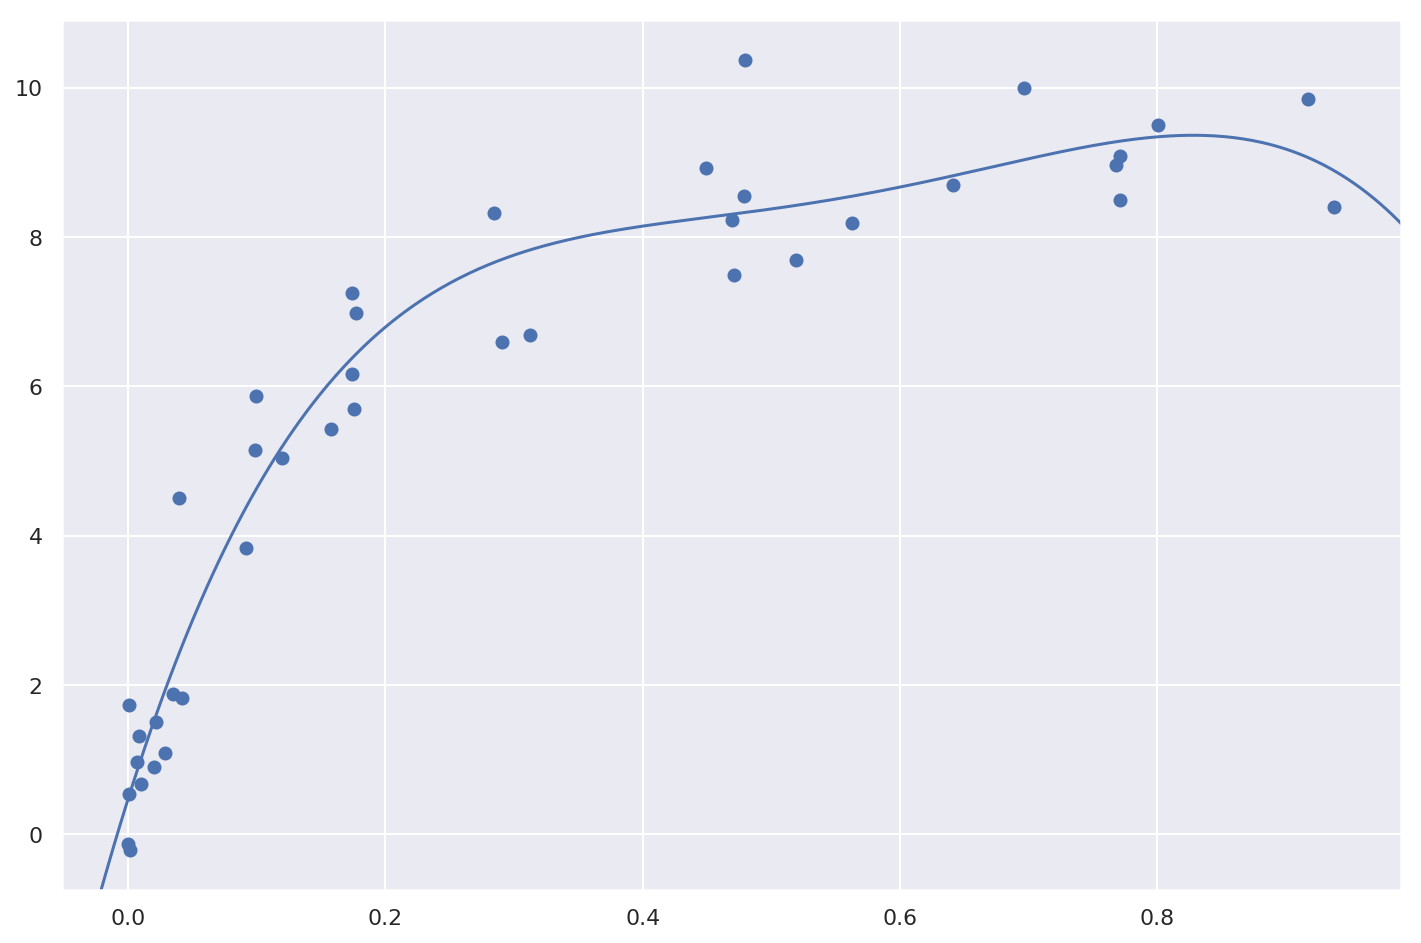

In [22]:
model = grid.best_estimator_

plt.figure(figsize=(12,8))
plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = model.fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test, hold=True);
plt.axis(lim);

La búsqueda grillada provee más opciones, incluyendo la posibilidad de usar una función de desempeño propia, de paralelizar la computación, de hacer búsquedas aleatorias en el espacio de parámetros, entre otras. 
Veremos ejemplos más adelante en los que exploraremos esto. De momento, revisa la documentación de [búsqueda grillada](http://Scikit-Learn.org/stable/modules/grid_search.html).

## Resumen

En esta sección hemos comenzado a explorar el concepto de validación de modelos y optimización de hiperparámetros, enfocándonos en los aspectos intuitivos del trade-off entre sesgo y varianza, y de cómo afectan los resultados de ajuste a los datos.
En particular, encontramos que el uso de un set de validación o un enfoque de validación cruzada es _vital_ a la hora de configurar parámetros para evitar sobreajustar en modelos más complejos o flexibles.

Más adelante discutiremos los detalles de modelos particularmente útiles, y a través de esa exploración discutiremos las configuraciones posibles para esos modelos, y el cómo dicha configuración afecta la complejidad de los modelos.
Por eso, ¡recuerda las lecciones de esta sección a medida que avancemos en las clases!

## Créditos

![](figures/PDSH-cover.png)

Este notebook contiene un extracto del libro [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) por Jake VanderPlas; el contenido también está disponible en [GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).

El texto se distribuye bajo una licencia [CC-BY-NC-ND](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), y el código se distribuye bajo la licencia [MIT](https://opensource.org/licenses/MIT). Si te parece que este contenido es útil, por favor considera apoyar el trabajo [comprando el libro](http://shop.oreilly.com/product/0636920034919.do).

Traducción al castellano por [Eduardo Graells-Garrido](http://datagramas.cl), liberada bajo las mismas condiciones.